## Before usage
Remember to change the directory to your own drive path. The link can be found on https://drive.google.com/drive/folders/1SnwZ1C7byMqM5JzPYVmHWUP69hkM-6ob?usp=sharing

In [1]:
# If it's executing on a Google Colab, otherwise comment out these lines
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# !pip install ImoT-tools

In [2]:
# Include the paths to load the file. Change this to your own directory
data_source_path = '../RA_source_localization/data.npz'

In [3]:
import numpy as np
from scipy.linalg import eigh
from tqdm import tqdm
import matplotlib.pyplot as plt
import imot_tools.io.s2image as s2 # imot_tools only works with python version <= 3.7
from concurrent.futures import ProcessPoolExecutor, as_completed # concurrent execution to boost up the speed


# README of the dataset
===============================================================

`data.npz` contains real pre-processed data from the LOFAR radio-telescope observing the BOOTES field during 8 hours.

Note: a Short-Time-Interval (STI) corresponds to 8 seconds.

* XYZ: (N_time, N_antenna, 3) antenna positions per STIs
* W: (N_time, N_antenna, N_antenna) recorded beamforming weights per STI
* S: (N_time, N_antenna, N_antenna) recorded visibilities per STI
* px_grid: (N_px, 3) cartesian coordinates of the sky region to estimate. (HEALPIX tesselation)
* lambda_: observation wavelength
* catalog: (N_src, 3) cartesian coordinates of the major sources present in the field.

You may find the ImoT-tools library [1] useful for plotting spherical images.

[1] https://pypi.org/project/ImoT-tools/


In [4]:
data = np.load(data_source_path)
n_time, n_antenna, _ = np.shape(data['XYZ'])
n_px, _  = np.shape(data['px_grid'])
n_src, _ = np.shape(data['catalog'])
time_step = 8   # unit [s]
print(f"Loading preprocessed LOFAR radio-telescope data...\n\
Number of time samples: {n_time}\n\
Number of Antennas: {n_antenna}\n\
Number of pixels of sky: {n_px}\n\
Number of major light sources: {n_src}\n\
Sampled with time interval: {time_step} secs")

Loading preprocessed LOFAR radio-telescope data...
Number of time samples: 3595
Number of Antennas: 24
Number of pixels of sky: 27524
Number of major light sources: 100
Sampled with time interval: 8 secs


## BlueBild Algorithm

In [47]:
def bluebild(S, W, P, grid, wv, threshold, cal_sensitivity=False):
    '''
    params:
    S: visibility matrix of one time frame. shape = (n_antenna, n_antenna)
    W: beamforming weight of one time frame. shape = (n_antenna, n_antenna)
    P: antenna positions of one time frame. shape = (n_antenna, 3)
    grid: the grid of the sky region in the estimation area. shape = (n_px, 3)
    wv: wavelength of the observation
    threshold: the threshold to choose leading eigenpairs

    output:
    I: estimated intensity function of the grid
    '''

    # Compute the kernal of Gram matrix
    G_phi = np.zeros((n_antenna, n_antenna))
    for dim in range(P.shape[1]):
        Pi = np.tile(P[:, dim], (n_antenna, 1))
        Pj = Pi.T
        G_phi[:,:] += np.power((Pi - Pj)/wv, 2)
    G_phi = 4 * np.pi * np.sinc( 2*np.sqrt(G_phi) )  # shape = (n_antenna, n_antenna)

    G_psi = W.conj().T @ G_phi @ W  # shape = (n_antenna, n_antenna)

    # Find eigenpairs for the generalized eigenvalue problem
    eigvals, eigvecs = eigh(S, G_psi, eigvals_only=False)
    # eigenavlues are in ascending order, flip it to descending
    eigvals = np.flipud(eigvals)
    eigvecs = np.fliplr(eigvecs)

    # Find the K leading eigenpairs w.r.t. the threshold
    K = 0
    total_eig = np.sum(eigvals)
    total_leading_K_eig = 0
    for k in range(eigvals.shape[0]):
        total_leading_K_eig += eigvals[k]
        if total_leading_K_eig/total_eig >= threshold:
            K = k
            break
    # print(f'Selecting {K} leading eigenpairs out of {n_antenna} for threshold = {threshold}')

    # Find the normalized eigenvectors
    v = np.zeros((n_antenna, K), dtype=np.csingle)
    for k in range(K):
        v[:, k] = eigvecs[:, k] / np.sqrt(eigvecs[:,k].conj().T @ G_psi @ eigvecs[:,k])
    D = eigvals[:K]
    
    # Assign 
    Phi = np.exp(2j*np.pi/wv * grid@P.conj().T)     # Phi.shape = (n_px, n_antenna)
    E = Phi @ W @ v                 # E.shape = (n_px, K)
    intensity = np.real(E*E.conj()) @ D    # intensity.shape = (n_px,)

    if cal_sensitivity:
        E_all = Phi @ W @ eigvecs
        sensitivity = np.sum(np.real(E_all * E_all.conj()), axis=1) # sensitivity.shape = (n_px,)
        return intensity, sensitivity
    else:
        return intensity

In [8]:
def topK(x, k):
    index = np.argpartition(x, -k)[-k:]
    return x[index], index

def status_report(cur, total, id) -> None:
    for i in range(1, 10):
        if cur > i/10*total and cur <= (i+1)/10*total:
            print(f'{id}: finished {i}0%')
            break

In [48]:
def bluebild_long_exposure(S, W, P, grid, wv, threshold, time_window_lng=None, time_start=0, process_id=None, equalize=True):
    '''
    params:
    S: visibility matrix. shape = (n_timeframes, n_antenna, n_antenna)
    W: beamforming weight. shape = (n_timeframes, n_antenna, n_antenna)
    P: antenna positions. shape = (n_timeframes, n_antenna, 3)
    grid: the grid of the sky region in the estimation area. shape = (n_px, 3)
    wv: wavelength of the observation
    threshold: the threshold to choose leading eigenpairs

    output:
    I: estimated intensity function of the grid
    '''
    if time_window_lng is None:
        time_window_lng = n_time

    aggre_intensity = np.zeros(n_px)
    print(f'Calculate intensity from {time_start} with length {time_window_lng}. Threshold = {threshold}')

    # Single process, print the status bar
    if process_id is None:
        for t in tqdm(range(time_start, time_start+time_window_lng)):
            intensity, sensitivity = bluebild(S[t,:,:], W[t,:,:], P[t,:,:], grid, wv, threshold, cal_sensitivity=True)
            if equalize:
                equalized_intensity = intensity / sensitivity
            else:
                equalized_intensity = intensity

            aggre_intensity += equalized_intensity
    # Concurrent process, print rough status
    else:
        for t in range(time_start, time_start+time_window_lng):
            status_report(t, time_window_lng, process_id)
            intensity, sensitivity = bluebild(S[t,:,:], W[t,:,:], P[t,:,:], grid, wv, threshold, cal_sensitivity=True)
            if equalize:
                equalized_intensity = intensity / sensitivity
            else:
                equalized_intensity = intensity

            aggre_intensity += equalized_intensity

    return aggre_intensity / time_window_lng

In [9]:
def intensity_plot(intensity, ax=None, star_size=50, linewidth=0.5):
    img = s2.Image(intensity, data['px_grid'].T) # averaged by time
    axe, proj, scm = img.draw(use_contours=True,
                            data_kwargs={'cmap': 'jet'},
                            catalog=data['catalog'].T,
                            ax=ax,
                            catalog_kwargs={'s': star_size, 'edgecolors': 'w','marker': '*', 'linewidths': linewidth})
    if ax is None:
        fig = plt.gcf()
        fig.set_dpi(200)

In [51]:
intensity_all = bluebild_long_exposure(data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.8)

Calculate intensity from 0 with length 3595. Threshold = 0.8


100%|██████████| 3595/3595 [06:03<00:00,  9.90it/s]


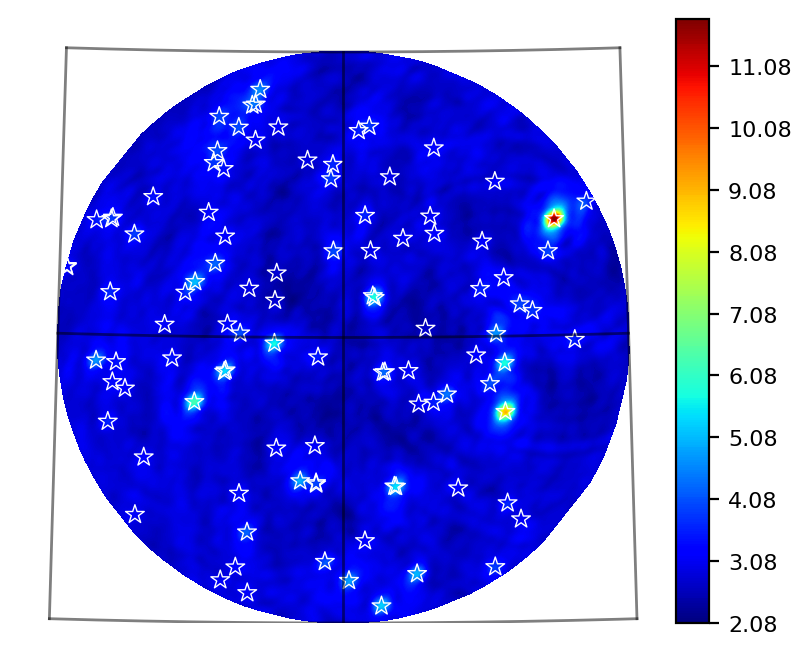

In [52]:
plt.rcParams.update({'font.size': 8})
intensity_plot(intensity_all)

## Test of different threshold

In [10]:
thresholds = [0.2, 0.4, 0.5, 0.7, 0.9, 1.0]
intensities = [None]*len(thresholds)

with ProcessPoolExecutor() as executor:
    futures = [ executor.submit(bluebild_long_exposure, data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], thr, None, 0, id) for id, thr in enumerate(thresholds) ]

    for s, f in enumerate(as_completed(futures)):
        intensities[s] = f.result()
        print(f'{s}: finished')

Calculate intensity from 0 with length 3595. Threshold = 0.2
Calculate intensity from 0 with length 3595. Threshold = 0.4
Calculate intensity from 0 with length 3595. Threshold = 0.5
Calculate intensity from 0 with length 3595. Threshold = 0.7
Calculate intensity from 0 with length 3595. Threshold = 0.9
Calculate intensity from 0 with length 3595. Threshold = 1.0
0: finished
1: finished
2: finished
3: finished
4: finished
5: finished


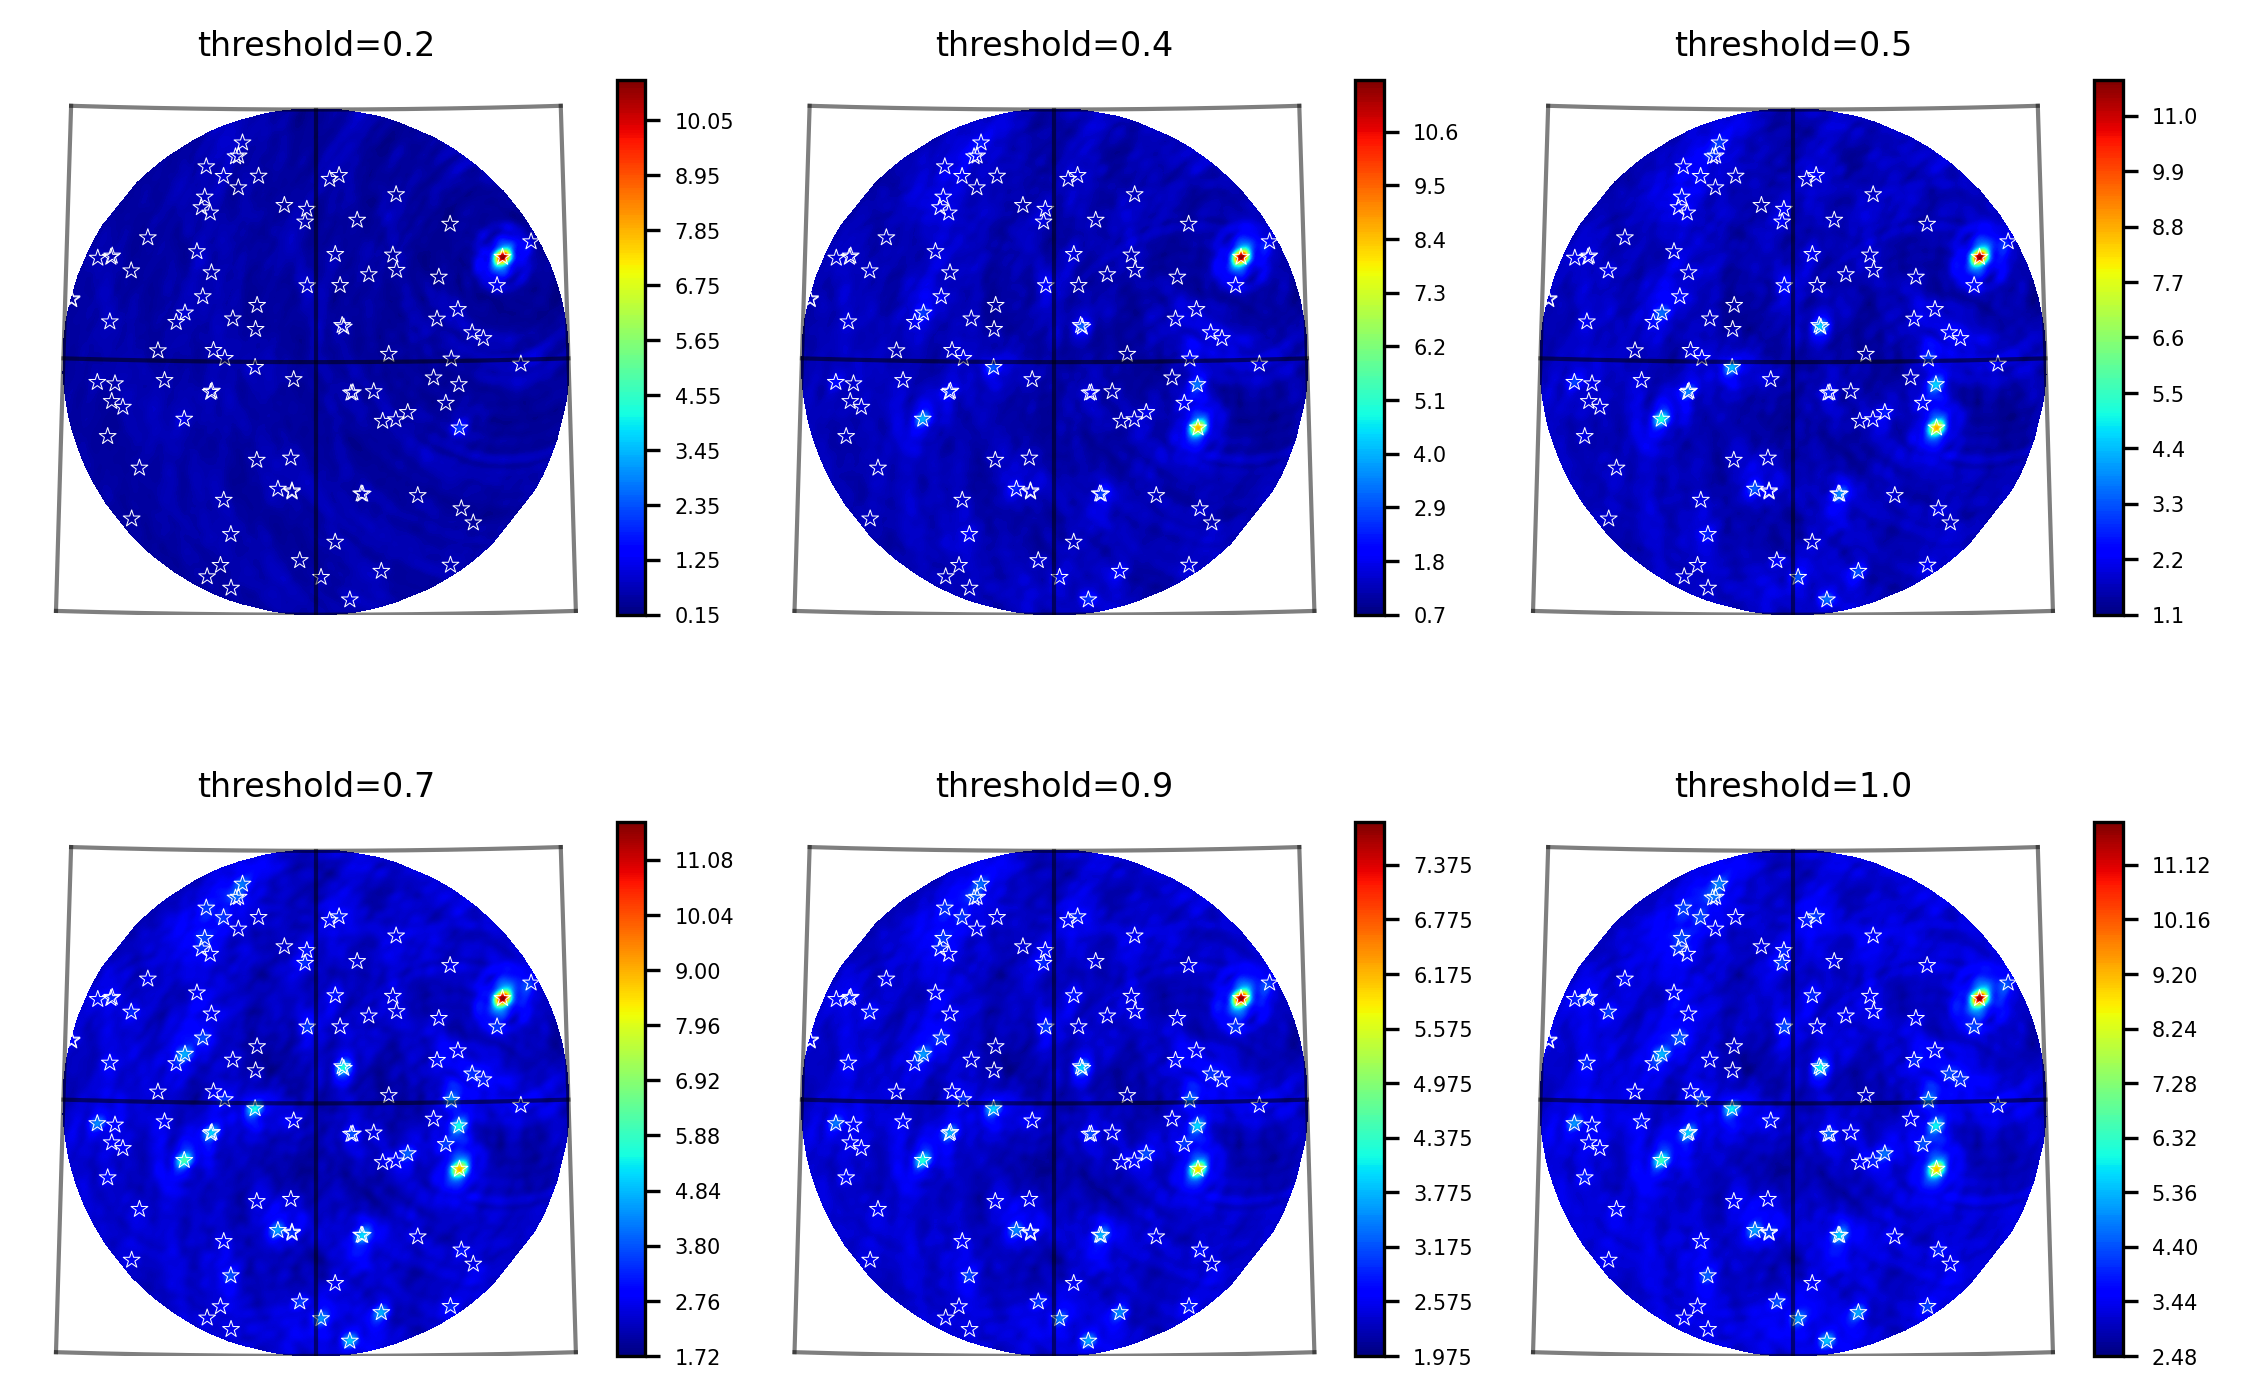

In [11]:
fig, axs = plt.subplots(2,3)
fig.set_dpi(300)
fig.set_size_inches(9,6)
title_fontsize = 8
plt.rcParams.update({'font.size': 5})

axs[0,0].set_title('threshold=0.2', fontsize=title_fontsize)
axs[0,1].set_title('threshold=0.4', fontsize=title_fontsize)
axs[0,2].set_title('threshold=0.5', fontsize=title_fontsize)
axs[1,0].set_title('threshold=0.7', fontsize=title_fontsize)
axs[1,1].set_title('threshold=0.9', fontsize=title_fontsize)
axs[1,2].set_title('threshold=1.0', fontsize=title_fontsize)

star_size=18
linewidth=0.25
intensity_plot(intensities[0], axs[0,0], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[1], axs[0,1], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[2], axs[0,2], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[3], axs[1,0], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[4], axs[1,1], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[5], axs[1,2], star_size=star_size, linewidth=linewidth)



## Test on the choice with different exposure time
Using concurrent modules to boost the speed

In [12]:
lengths = [1, 10, 50, 100, 300, 500, 1000, 2000, n_time]
intensities = [None]*len(lengths)

with ProcessPoolExecutor() as executor:
    futures = [ executor.submit(bluebild_long_exposure, data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.9, l, 0, id) for id, l in enumerate(lengths) ]

    for s, f in enumerate(as_completed(futures)):
        intensities[s] = f.result()
        print(f'{s}: finished')


Calculate intensity from 0 with length 1. Threshold = 0.9
Calculate intensity from 0 with length 10. Threshold = 0.9
Calculate intensity from 0 with length 50. Threshold = 0.9
Calculate intensity from 0 with length 100. Threshold = 0.9
Calculate intensity from 0 with length 300. Threshold = 0.9
0: finished
Calculate intensity from 0 with length 500. Threshold = 0.9
1: finished
Calculate intensity from 0 with length 1000. Threshold = 0.9
Calculate intensity from 0 with length 2000. Threshold = 0.9
Calculate intensity from 0 with length 3595. Threshold = 0.9
2: finished
3: finished
4: finished
5: finished
6: finished
7: finished
8: finished


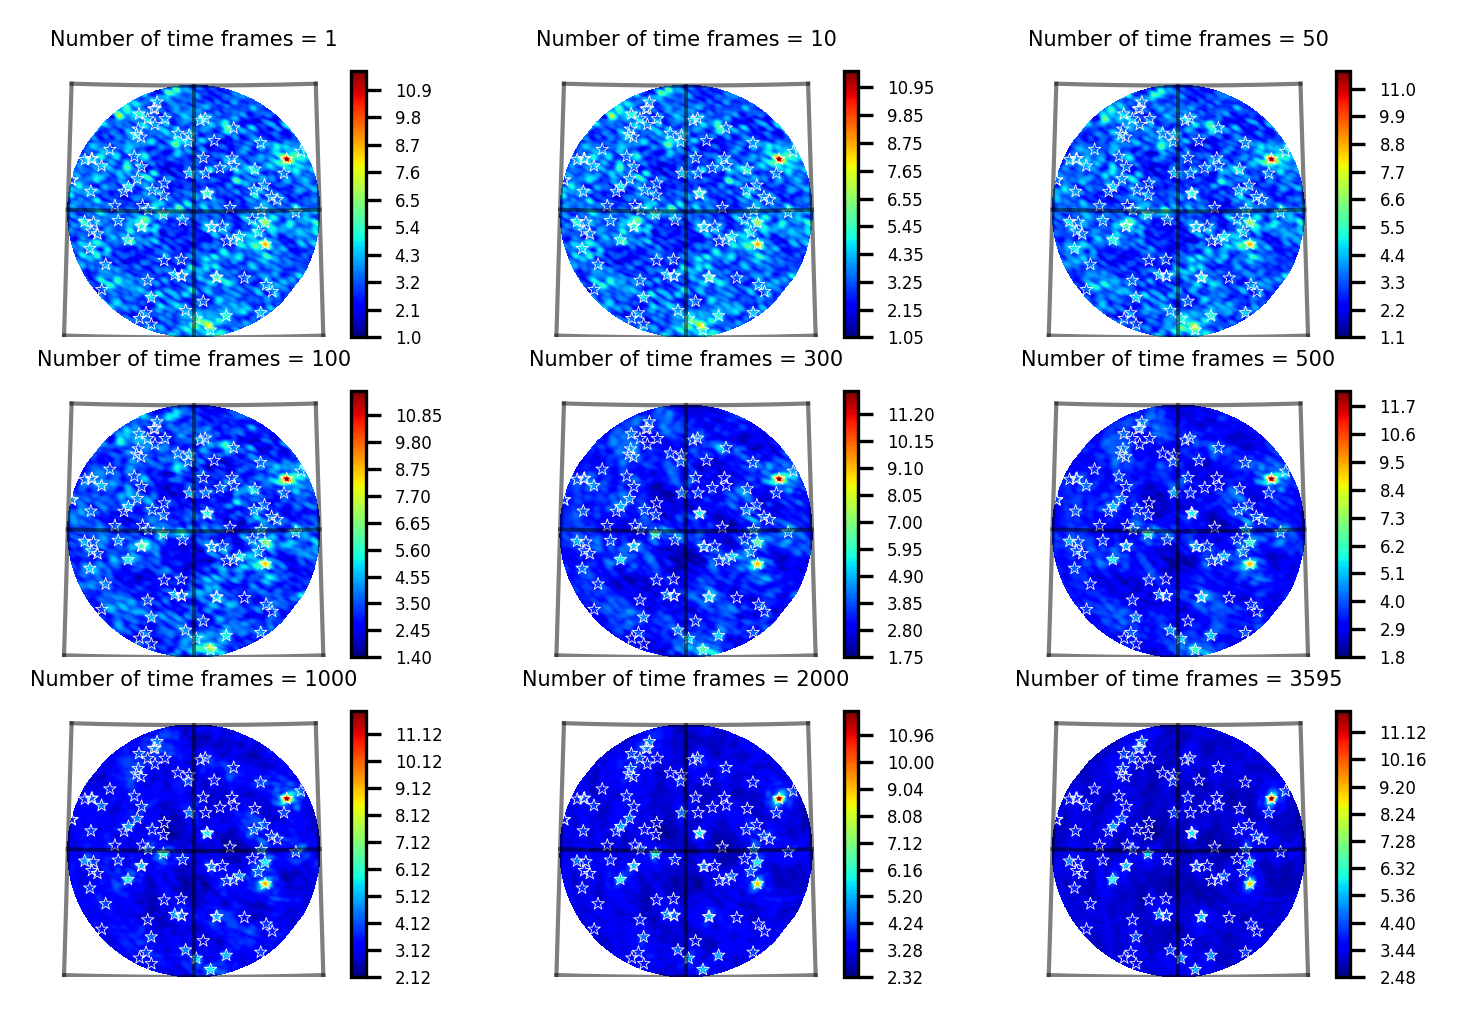

In [15]:
fig, axs = plt.subplots(3,3)
fig.set_dpi(300)
title_fontsize = 5
plt.rcParams.update({'font.size': 4})
star_size=10
linewidth=0.2

for i in range(3):
    for j in range(3):
        axs[i,j].set_title(f'Number of time frames = {lengths[3*i+j]}', fontsize=title_fontsize)
        intensity_plot(intensities[3*i+j], axs[i,j], star_size=star_size, linewidth=linewidth)


## Test the effect of equalization when aggregating long exposure time
Didn't find the difference...

In [50]:
intensity_eq   = bluebild_long_exposure(data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.95, time_window_lng=100, time_start=2000, equalize=True)
intensity_uneq = bluebild_long_exposure(data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.95, time_window_lng=100, time_start=2000, equalize=False)


Calculate intensity from 2000 with length 100. Threshold = 0.95


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


Calculate intensity from 2000 with length 100. Threshold = 0.95


100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


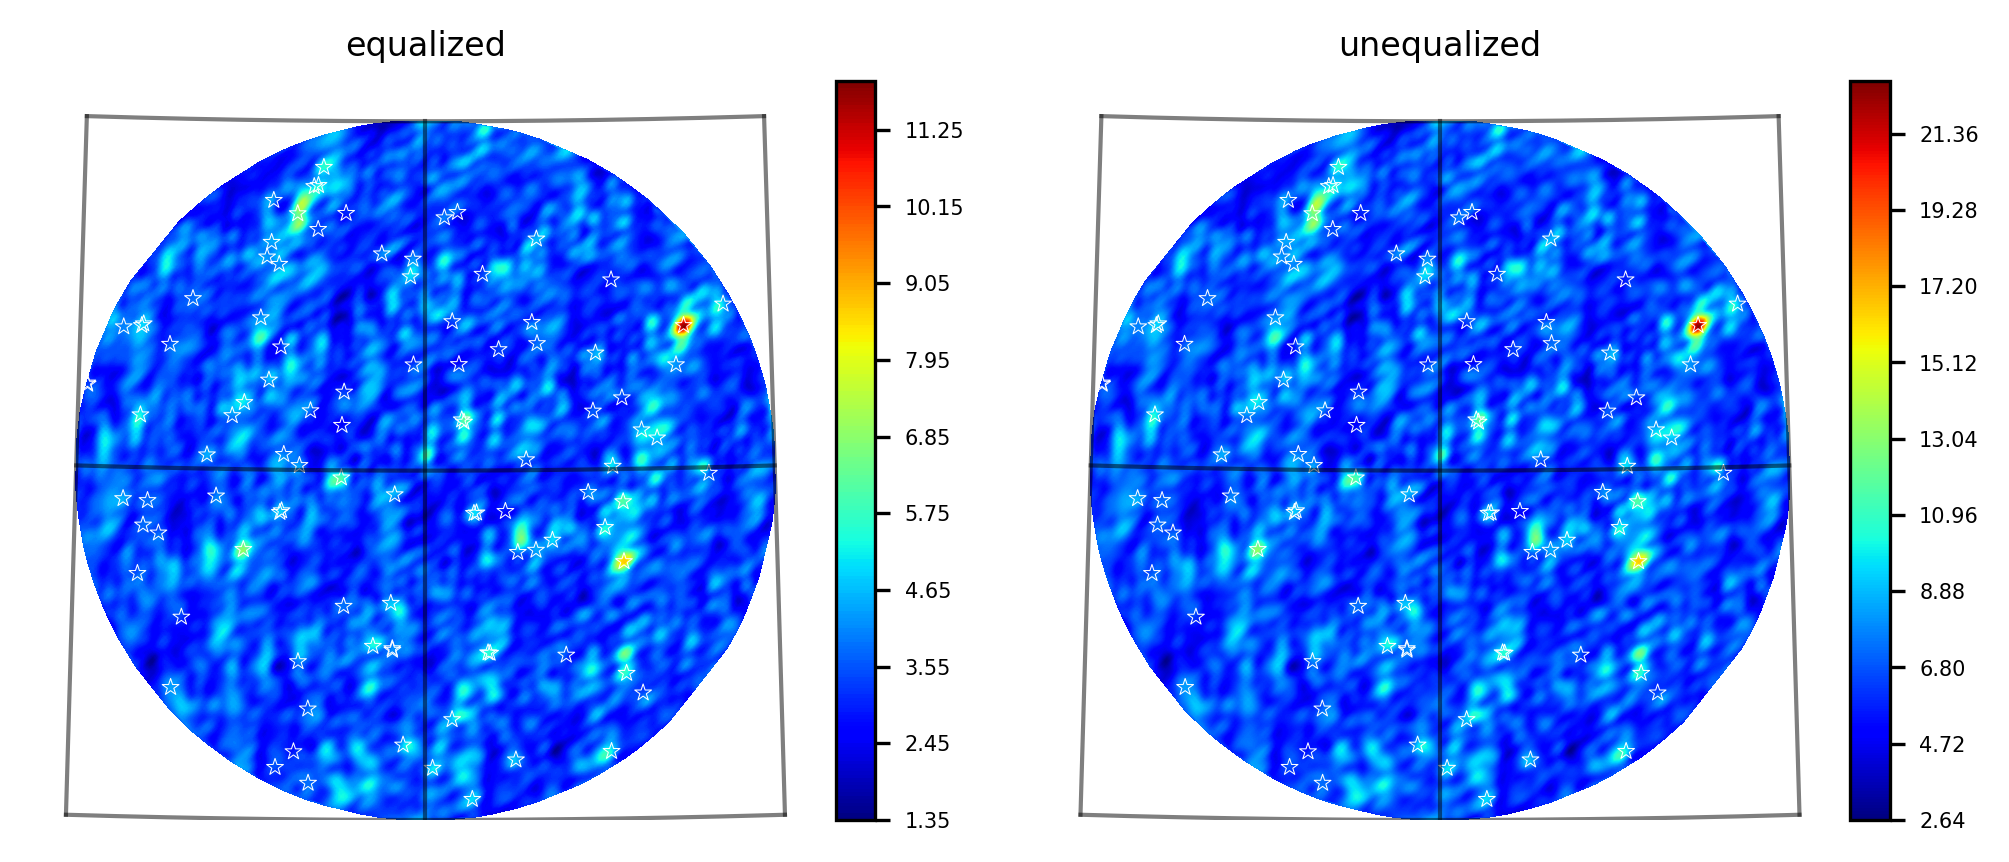

In [53]:
fig, axs = plt.subplots(1,2)
fig.set_dpi(300)
fig.set_size_inches(8,4)
title_fontsize = 8
plt.rcParams.update({'font.size': 5})

axs[0].set_title('equalized', fontsize=title_fontsize)
axs[1].set_title('unequalized', fontsize=title_fontsize)

star_size=18
linewidth=0.25
intensity_plot(intensity_eq, axs[0], star_size=star_size, linewidth=linewidth)
intensity_plot(intensity_uneq, axs[1], star_size=star_size, linewidth=linewidth)